# Analyzing Joe Biden's and Donald Trump's tweets during the COVID-19 pandemic.

# Table of Contents

* [1. Importing Packages](#importing_packages)
* [2. Loading the Data](#load_data)
* [3. Data Cleaning and Preparation](#data_clean)
* [4. Exploring the Data: Aggregate and Frequency statistics](#explore_data)
* [5. Sentiment Analysis](#sentiment_analysis)
* [6. Topic Modeling](#topic_modeling)
* [7. Classification](#classification)

# 1. Importing packages <a class="anchor" id="importing_packages">

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import everygrams
from nltk import ngrams
from nltk import FreqDist
from nltk.tokenize.treebank import TreebankWordDetokenizer
from textblob import TextBlob
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm, metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.options.mode.chained_assignment = None
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Load Data<a class="anchor" id="load_data">

In [2]:
trump_df = pd.read_csv("trump.csv")
biden_df = pd.read_csv("biden.csv")

In [3]:
trump_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,RT @USNoodlesA: 🔥This amazing American @TheLeo...,08-09-2020 02:30:54,12113,0,True,1292287207533936645
1,RT @drawandstrike: ADDENDUM:This is 100% corre...,08-09-2020 02:26:15,8666,0,True,1292286038518280192
2,RT @hale_razor: Just think of it as DACA for A...,08-09-2020 02:24:25,9198,0,True,1292285575454691330
3,RT @KurtSchlichter: Why is the DACA executive ...,08-09-2020 02:21:58,6692,0,True,1292284959533793282
4,RT @marklevinshow: 1. President Trump had no c...,08-09-2020 02:21:32,19090,0,True,1292284850125316096
...,...,...,...,...,...,...
7028,I will be signing our very large and comprehen...,12-31-2019 14:16:40,22730,95208,False,1212014713808273410
7029,President Putin of Russia called to thank me a...,12-31-2019 14:06:09,29025,141918,False,1212012065440894976
7030,Armed congregants quickly stopped a crazed chu...,12-31-2019 13:53:10,25719,114701,False,1212008798849814528
7031,Iran killed an American contractor wounding ma...,12-31-2019 12:02:47,37287,150318,False,1211981022084128768


In [4]:
biden_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,We can’t let Donald Trump destroy the U.S. Pos...,2020-08-09 19:15:00,10158,54082,False,1292539896465416192
1,It's been six years since Michael Brown's life...,2020-08-09 17:00:00,6281,34913,False,1292505925685633025
2,Our planet can’t take four more years of Donal...,2020-08-09 15:00:02,17283,102639,False,1292475731172261894
3,RT @TeamJoe: We seriously can’t wait to see wh...,2020-08-09 14:24:10,797,0,True,1292466709006344193
4,Giving the Trump administration another four y...,2020-08-09 13:00:00,10095,40664,False,1292445526005252096
...,...,...,...,...,...,...
3195,RT @TeamJoe: Let's clear up the confusion abou...,2019-07-31 13:22:52,248,0,True,1156555830222831617
3196,RT @TeamJoe: A medida que los ricos se hacen m...,2019-07-31 02:13:18,54,0,True,1156387329663258624
3197,"RT @TeamJoe: As the rich get richer, middle-cl...",2019-07-31 02:13:16,165,0,True,1156387322587488257
3198,RT @TeamJoe: President Trump doesn’t get the b...,2019-07-31 01:57:35,215,0,True,1156383375030214657


# 3. Data Cleaning and Preparation<a class="anchor" id="data_clean">

### Functions for text cleaning

In [5]:
global stop_words
stop_words = stopwords.words('english')
custom_stopwords = ['amp', 'youre', 'dont','wont', 'got']
stop_words.extend(custom_stopwords)

def detect_language(X):
    from langdetect import detect
    try:
        lang = detect(X)
        return(lang)
    except:
        return("other")
    
def remove_url_punctuation(X):
    """ Replace URLS, punctuations, hashtags found in a text string with nothing.
    Change to lowercase"""
    # Try with just simple /w+ regex.       
    url_pattern = re.compile(r'https:?://\S+|www\.\S+')
    replace_url = url_pattern.sub(r'', str(X))
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', replace_url).lower()
    no_punct = no_punct.replace('\n', ' ')
    no_punct = no_punct.replace('\t', ' ')
    return no_punct

def split_words(X):
    """"" Split tweets into words for NLP"""
    split_word_list = X.split(" ")
    return split_word_list

def remove_stopwords(X):
    filtered_words = []
    global stop_words
    for word in X:
        if word not in stop_words and len(word) > 2 and word != 'nan':
            filtered_words.append(word)
    return filtered_words

# All the above in one function
def basic_processing(text):
    clean_text = remove_url_punctuation(text)
    tokens = split_words(clean_text)
    tokens = remove_stopwords(tokens) 
    return tokens

### Get Biden tweets since the emergence of [COVID19](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200121-sitrep-1-2019-ncov.pdf). Trump dataset already filtered by start date. 

In [6]:
START_DATE = pd.to_datetime('31-12-2019')
biden_df['created_at'] = pd.to_datetime(biden_df['created_at'])
trump_df['created_at'] = pd.to_datetime(trump_df['created_at'])
biden_df = biden_df.loc[biden_df['created_at'] >= START_DATE]

### Remove retweets

In [7]:
# Note: Not using is_retweet column since data incorrectly labelled from trumptwitterarchive. 
# Using starts with 'RT' is more reliable.
trump_retweets = trump_df[trump_df.text.str.startswith('RT ') == True]
biden_retweets = biden_df[biden_df.text.str.startswith('RT ') == True]
print('Trump has', len(trump_retweets), 'retweets.', round(len(trump_retweets)/len(trump_df) * 100, 2), '% of his tweets are retweets.')
print('Biden has', len(biden_retweets), 'retweets.', round(len(biden_retweets)/len(biden_df) * 100,2), '% of his tweets are retweets.')

Trump has 3843 retweets. 54.64 % of his tweets are retweets.
Biden has 73 retweets. 3.79 % of his tweets are retweets.


In [8]:
trump_df = trump_df[trump_df.text.str.startswith('RT ') == False]
biden_df = biden_df[biden_df.text.str.startswith('RT ') == False]

### Remove non-English tweets

In [9]:
trump_df['en'] = trump_df['text'].apply(detect_language)
biden_df['en'] = biden_df['text'].apply(detect_language)

trump_df = trump_df[trump_df['en'] == 'en']
biden_df = biden_df[biden_df['en'] == 'en']

### Remove punctuation, special characters, and hashtags in tweets

In [10]:
trump_df['clean_text'] = trump_df['text'].apply(remove_url_punctuation)
biden_df['clean_text'] = biden_df['text'].apply(remove_url_punctuation)
print(trump_df['text'].head())
print('-------------------------------------')
print(trump_df['clean_text'].head())

12                Major News Conference in Ten Minutes!
13    Sleepy Joe Biden just agreed with the Radical ...
21    Big wins in Tennessee and Kansas! Congratulati...
22    I will be doing a news conference on the China...
23    ...At 3pm this afternoon spoke to President Ao...
Name: text, dtype: object
-------------------------------------
12                 major news conference in ten minutes
13    sleepy joe biden just agreed with the radical ...
21    big wins in tennessee and kansas congratulatio...
22    i will be doing a news conference on the china...
23    at 3pm this afternoon spoke to president aoun ...
Name: clean_text, dtype: object


### Tokenize Tweets

In [11]:
trump_df['tokens'] = trump_df['clean_text'].apply(split_words)
biden_df['tokens'] = biden_df['clean_text'].apply(split_words)
print(trump_df['clean_text'].head())
print('-------------------------------------')
print(trump_df['tokens'].head())

12                 major news conference in ten minutes
13    sleepy joe biden just agreed with the radical ...
21    big wins in tennessee and kansas congratulatio...
22    i will be doing a news conference on the china...
23    at 3pm this afternoon spoke to president aoun ...
Name: clean_text, dtype: object
-------------------------------------
12          [major, news, conference, in, ten, minutes]
13    [sleepy, joe, biden, just, agreed, with, the, ...
21    [big, wins, in, tennessee, and, kansas, congra...
22    [i, will, be, doing, a, news, conference, on, ...
23    [at, 3pm, this, afternoon, spoke, to, presiden...
Name: tokens, dtype: object


### Remove Stop Words with NLTK

In [12]:
trump_df['tokens'] = trump_df['tokens'].apply(remove_stopwords)
biden_df['tokens'] = biden_df['tokens'].apply(remove_stopwords)
print(trump_df['tokens'].head())

12              [major, news, conference, ten, minutes]
13    [sleepy, joe, biden, agreed, radical, left, de...
21    [big, wins, tennessee, kansas, congratulations...
22    [news, conference, chinavirus, announced, good...
23    [3pm, afternoon, spoke, president, aoun, leban...
Name: tokens, dtype: object


In [13]:
trump_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,en,clean_text,tokens
12,Major News Conference in Ten Minutes!,2020-08-08 20:05:54,21356,155572,False,1292190319845478402,en,major news conference in ten minutes,"[major, news, conference, ten, minutes]"
13,Sleepy Joe Biden just agreed with the Radical ...,2020-08-08 19:28:59,41681,151462,False,1292181029541879812,en,sleepy joe biden just agreed with the radical ...,"[sleepy, joe, biden, agreed, radical, left, de..."
21,Big wins in Tennessee and Kansas! Congratulati...,2020-08-07 22:58:31,16038,69506,False,1291871370197041152,en,big wins in tennessee and kansas congratulatio...,"[big, wins, tennessee, kansas, congratulations..."
22,I will be doing a news conference on the China...,2020-08-07 22:32:51,24848,122810,False,1291864911509938176,en,i will be doing a news conference on the china...,"[news, conference, chinavirus, announced, good..."
23,...At 3pm this afternoon spoke to President Ao...,2020-08-07 22:31:12,12555,67284,False,1291864495648890881,en,at 3pm this afternoon spoke to president aoun ...,"[3pm, afternoon, spoke, president, aoun, leban..."
...,...,...,...,...,...,...,...,...,...
7028,I will be signing our very large and comprehen...,2019-12-31 14:16:40,22730,95208,False,1212014713808273410,en,i will be signing our very large and comprehen...,"[signing, large, comprehensive, phase, one, tr..."
7029,President Putin of Russia called to thank me a...,2019-12-31 14:06:09,29025,141918,False,1212012065440894976,en,president putin of russia called to thank me a...,"[president, putin, russia, called, thank, info..."
7030,Armed congregants quickly stopped a crazed chu...,2019-12-31 13:53:10,25719,114701,False,1212008798849814528,en,armed congregants quickly stopped a crazed chu...,"[armed, congregants, quickly, stopped, crazed,..."
7031,Iran killed an American contractor wounding ma...,2019-12-31 12:02:47,37287,150318,False,1211981022084128768,en,iran killed an american contractor wounding ma...,"[iran, killed, american, contractor, wounding,..."


In [14]:
biden_df

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,en,clean_text,tokens
0,We can’t let Donald Trump destroy the U.S. Pos...,2020-08-09 19:15:00,10158,54082,False,1292539896465416192,en,we cant let donald trump destroy the us postal...,"[cant, let, donald, trump, destroy, postal, se..."
1,It's been six years since Michael Brown's life...,2020-08-09 17:00:00,6281,34913,False,1292505925685633025,en,its been six years since michael browns life w...,"[six, years, since, michael, browns, life, tak..."
2,Our planet can’t take four more years of Donal...,2020-08-09 15:00:02,17283,102639,False,1292475731172261894,en,our planet cant take four more years of donald...,"[planet, cant, take, four, years, donald, trum..."
4,Giving the Trump administration another four y...,2020-08-09 13:00:00,10095,40664,False,1292445526005252096,en,giving the trump administration another four y...,"[giving, trump, administration, another, four,..."
5,The United States just passed 5 million report...,2020-08-09 01:00:01,18811,89240,False,1292264334287044609,en,the united states just passed 5 million report...,"[united, states, passed, million, reported, in..."
...,...,...,...,...,...,...,...,...,...
1919,"As we move into the New Year, there's one thin...",2019-12-31 23:30:00,7929,66753,False,1212153964206198789,en,as we move into the new year theres one thing ...,"[move, new, year, theres, one, thing, know, 20..."
1920,2019 was a year of record violence — it will b...,2019-12-31 22:02:37,981,3545,False,1212131972295929856,en,2019 was a year of record violence it will be...,"[2019, year, record, violence, moral, failure,..."
1921,Next year could give us one of two things: a n...,2019-12-31 20:45:00,468,1771,False,1212112439623458826,en,next year could give us one of two things a ne...,"[next, year, could, give, one, two, things, ne..."
1922,It will take years to repair the damage Betsy ...,2019-12-31 17:15:00,6359,24910,False,1212059591569297408,en,it will take years to repair the damage betsy ...,"[take, years, repair, damage, betsy, devos, sc..."


# 4. Exploring the Data: Aggregate and Frequency Statistics<a class="anchor" id="explore_data">

In [15]:
trump_df.describe()

,retweet_count,favorite_count,id_str
count,2657.000000,2657.000000,2.657000e+03
mean,24552.767030,110440.359804,1.252178e+18
std,16660.179996,81390.181044,2.226025e+16
min,0.000000,0.000000,1.211969e+18
25%,13499.000000,56753.000000,1.232899e+18
50%,20574.000000,91209.000000,1.253690e+18
75%,30969.000000,139267.000000,1.269842e+18
max,225693.000000,830795.000000,1.292190e+18


In [16]:
biden_df.describe()

,retweet_count,favorite_count,id_str
count,1816.000000,1.816000e+03,1.816000e+03
mean,8659.130507,4.217743e+04,1.251627e+18
std,12558.297676,6.887634e+04,2.239420e+16
min,11.000000,3.400000e+01,1.211809e+18
25%,2004.750000,8.139000e+03,1.233087e+18
50%,5228.500000,2.159700e+04,1.250233e+18
75%,11054.250000,4.984500e+04,1.270343e+18
max,332205.000000,1.658303e+06,1.292540e+18


## How engaging are their tweets?: Viewing the average number of retweets and favorites. 

#### Trump

In [17]:
trump_rt_avg = trump_df.mean()['retweet_count']
print("Trump retweet average:", trump_rt_avg)

Trump retweet average: 24552.76703048551


In [18]:
trump_favorite_avg = trump_df.mean()['favorite_count']
print("Trump favorite average:", trump_favorite_avg)

Trump favorite average: 110440.35980429055


In [19]:
trump_most_rts = trump_df.loc[trump_df['retweet_count'].idxmax()].text
print("Trump's most retweeted and favorited tweet:", trump_most_rts)

Trump's most retweeted and favorited tweet: The United States of America will be designating ANTIFA as a Terrorist Organization.


#### Biden

In [20]:
biden_rt_avg = biden_df.mean()['retweet_count']
print("Biden retweet average:", biden_rt_avg)

Biden retweet average: 8659.13050660793


In [21]:
biden_favorite_avg = biden_df.mean()['favorite_count']
print("Biden favorite average:", biden_favorite_avg)

Biden favorite average: 42177.43447136564


In [22]:
biden_most_rts = biden_df.loc[biden_df['retweet_count'].idxmax()].text
print("Biden's most retweeted and favorited tweet:", biden_most_rts)

Biden's most retweeted and favorited tweet: I can’t believe I have to say this, but please don’t drink bleach.


In [23]:
# Calculate how much more retweets and favorites trump gets on average than Biden
print("Trump gets", round(trump_rt_avg / biden_rt_avg, 2), "times more retweets than Biden." )
print("That's an increase of", round(100 * (trump_rt_avg - biden_rt_avg) / biden_rt_avg, 2) ,"%")

Trump gets 2.84 times more retweets than Biden.
That's an increase of 183.55 %


In [24]:
print("Trump gets", round(trump_favorite_avg / biden_favorite_avg, 2), "times more favorites than Biden." )
print("That's an increase of", round(100 * (trump_favorite_avg - biden_favorite_avg) / biden_favorite_avg, 2) ,"%")

Trump gets 2.62 times more favorites than Biden.
That's an increase of 161.85 %


## Looks like Trump gets much more retweets and favorites than Biden. Let's use boxplots to visualize the differences more clearly. 

C:\Users\david\anaconda3\envs\PythonCPU\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Trump vs Biden Retweets')

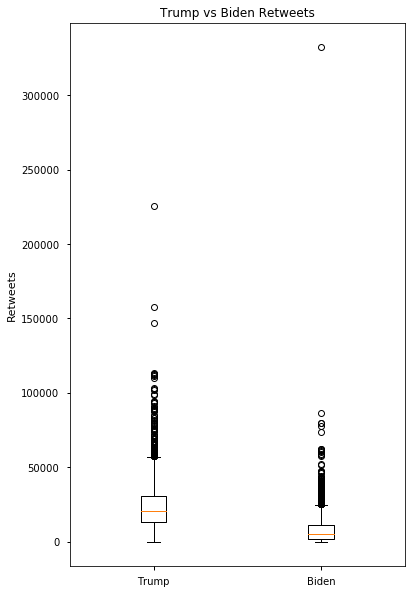

In [25]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(6, 10))
plt.boxplot([trump_df['retweet_count'], biden_df['retweet_count']], labels=['Trump', 'Biden'], autorange=False)

plt.ylabel('Retweets')
plt.title('Trump vs Biden Retweets')

C:\Users\david\anaconda3\envs\PythonCPU\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Trump vs Biden Favorites')

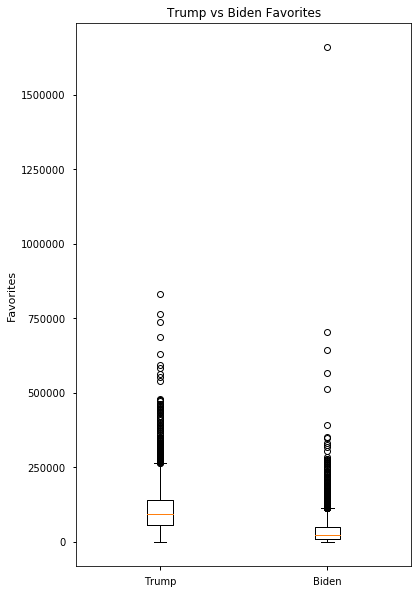

In [26]:
plt.figure(figsize=(6, 10))
plt.boxplot([trump_df['favorite_count'], biden_df['favorite_count']], labels=['Trump', 'Biden'], autorange=False)
plt.ylabel('Favorites')
plt.title('Trump vs Biden Favorites')

The box plots clearly show that on average Biden has less engagement than Trump on Twitter, except for his one outlier tweet that went viral. 

## Which words and n-grams do they use the most?

### Unigrams

In [27]:
trump_tokens = trump_df['tokens'].explode()
biden_tokens = biden_df['tokens'].explode()

trump_unigrams = FreqDist(ngrams(trump_tokens, 1))
biden_unigrams = FreqDist(ngrams(biden_tokens, 1))

[(('great',), 668),
 (('people',), 311),
 (('news',), 292),
 (('thank',), 285),
 (('fake',), 245),
 (('big',), 212),
 (('new',), 193),
 (('president',), 179),
 (('democrats',), 173),
 (('never',), 173),
 (('would',), 171),
 (('many',), 170),
 (('total',), 162),
 (('country',), 154),
 (('get',), 154),
 (('complete',), 152),
 (('job',), 152),
 (('nothing',), 150),
 (('joe',), 146),
 (('endorsement',), 146)]

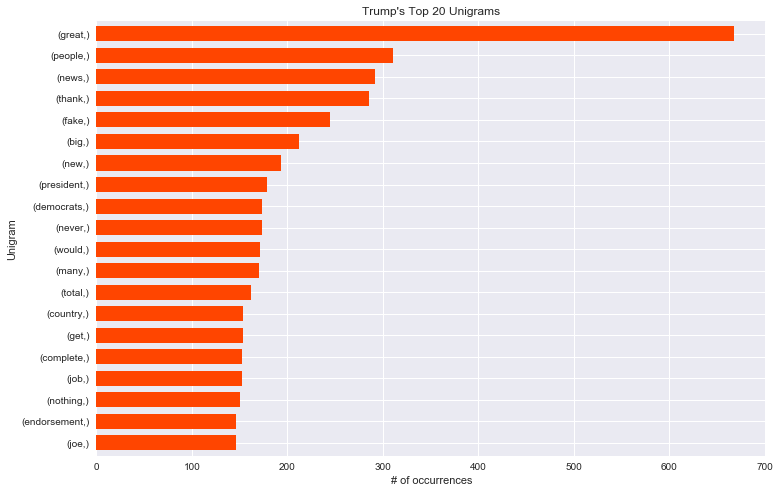

In [28]:
plt.style.use('seaborn')
NUM_NGRAMS = 20

pd.Series(ngrams(trump_tokens, 1)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='orangered', width=.7, figsize=(12,8))
plt.title("Trump's Top 20 Unigrams")
plt.ylabel('Unigram')
plt.xlabel('# of occurrences')
trump_unigrams.most_common(NUM_NGRAMS)

[(('trump',), 495),
 (('president',), 429),
 (('donald',), 426),
 (('need',), 335),
 (('one',), 230),
 (('nation',), 227),
 (('american',), 214),
 (('people',), 201),
 (('get',), 199),
 (('country',), 192),
 (('every',), 192),
 (('crisis',), 183),
 (('make',), 177),
 (('together',), 168),
 (('day',), 161),
 (('health',), 155),
 (('today',), 150),
 (('time',), 149),
 (('care',), 144),
 (('take',), 137)]

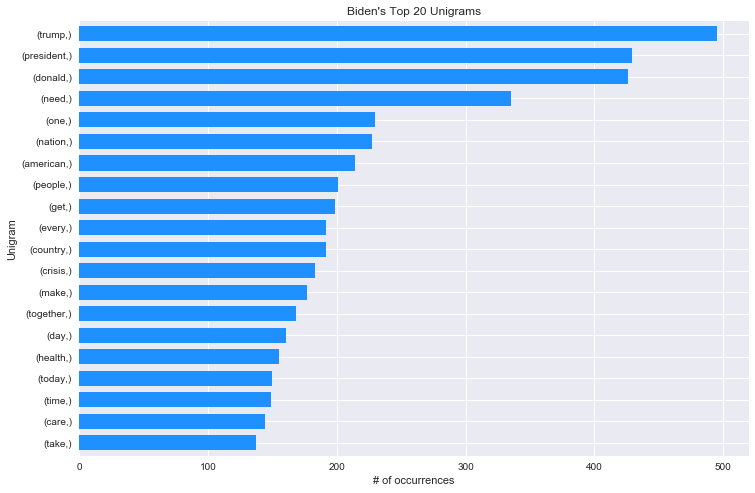

In [29]:
pd.Series(ngrams(biden_tokens, 1)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='dodgerblue', width=.7, figsize=(12,8))
plt.title("Biden's Top 20 Unigrams")
plt.ylabel('Unigram')
plt.xlabel('# of occurrences')
biden_unigrams.most_common(NUM_NGRAMS)

### Bigrams

In [30]:
trump_bigrams = FreqDist(ngrams(trump_tokens, 2))
biden_bigrams = FreqDist(ngrams(biden_tokens, 2))

[(('fake', 'news'), 190),
 (('complete', 'total'), 127),
 (('total', 'endorsement'), 126),
 (('radical', 'left'), 85),
 (('white', 'house'), 76),
 (('second', 'amendment'), 72),
 (('united', 'states'), 68),
 (('military', 'vets'), 67),
 (('sleepy', 'joe'), 65),
 (('great', 'state'), 62),
 (('new', 'york'), 61),
 (('great', 'job'), 60),
 (('joe', 'biden'), 57),
 (('mini', 'mike'), 52),
 (('republican', 'party'), 51),
 (('lamestream', 'media'), 51),
 (('nothing', 'democrats'), 50),
 (('impeachment', 'hoax'), 47),
 (('president', 'trump'), 39),
 (('federal', 'government'), 38)]

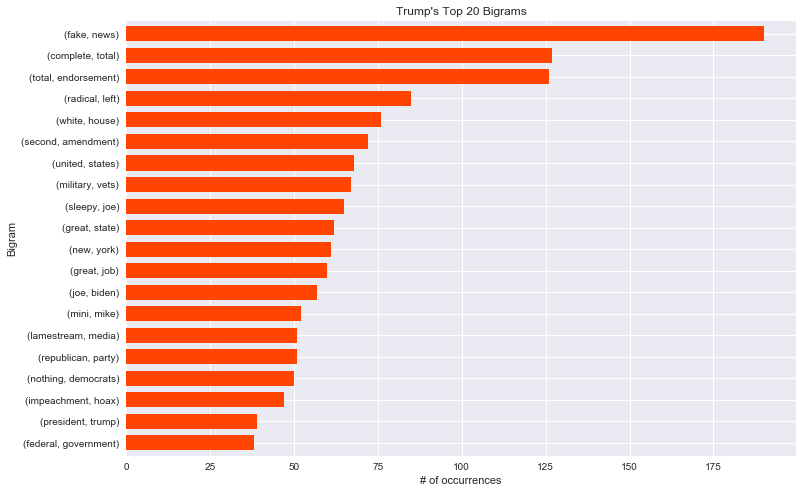

In [31]:
pd.Series(ngrams(trump_tokens, 2)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='orangered', width=.7, figsize=(12,8))
plt.title("Trump's Top 20 Bigrams")
plt.ylabel('Bigram')
plt.xlabel('# of occurrences')
trump_bigrams.most_common(NUM_NGRAMS)

[(('donald', 'trump'), 369),
 (('health', 'care'), 89),
 (('white', 'house'), 85),
 (('american', 'people'), 70),
 (('need', 'president'), 63),
 (('donald', 'trumps'), 56),
 (('president', 'trump'), 55),
 (('soul', 'nation'), 50),
 (('need', 'help'), 47),
 (('every', 'day'), 44),
 (('beat', 'donald'), 42),
 (('make', 'sure'), 38),
 (('four', 'years'), 33),
 (('across', 'country'), 33),
 (('battle', 'soul'), 31),
 (('day', 'one'), 30),
 (('climate', 'change'), 30),
 (('front', 'lines'), 30),
 (('middle', 'class'), 29),
 (('south', 'carolina'), 29)]

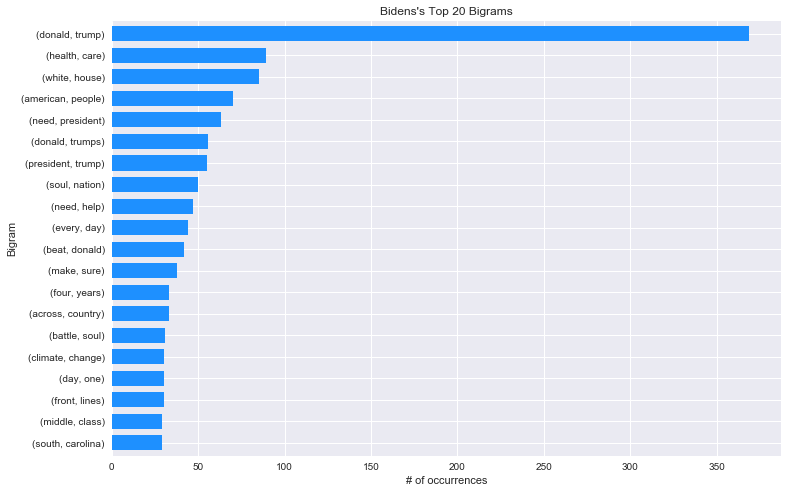

In [32]:
pd.Series(ngrams(biden_tokens, 2)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='dodgerblue', width=.7, figsize=(12,8))
plt.title("Bidens's Top 20 Bigrams")
plt.ylabel('Bigram')
plt.xlabel('# of occurrences')
biden_bigrams.most_common(NUM_NGRAMS)

### Trigrams

In [33]:
trump_trigrams = FreqDist(ngrams(trump_tokens, 3))
biden_trigrams = FreqDist(ngrams(biden_tokens, 3))

[(('complete', 'total', 'endorsement'), 125),
 (('sleepy', 'joe', 'biden'), 29),
 (('fake', 'news', 'media'), 28),
 (('radical', 'left', 'nothing'), 25),
 (('loves', 'military', 'vets'), 25),
 (('approval', 'rating', 'republican'), 24),
 (('rating', 'republican', 'party'), 24),
 (('left', 'nothing', 'democrats'), 24),
 (('fake', 'news', 'cnn'), 24),
 (('mini', 'mike', 'bloomberg'), 20),
 (('supporter', 'maga', 'agenda'), 17),
 (('radical', 'left', 'democrats'), 16),
 (('white', 'house', 'news'), 16),
 (('republican', 'party', 'thank'), 15),
 (('russia', 'russia', 'russia'), 14),
 (('cryin', 'chuck', 'schumer'), 14),
 (('house', 'news', 'conference'), 14),
 (('make', 'america', 'great'), 13),
 (('vets', 'second', 'amendment'), 12),
 (('corrupt', 'joe', 'biden'), 12)]

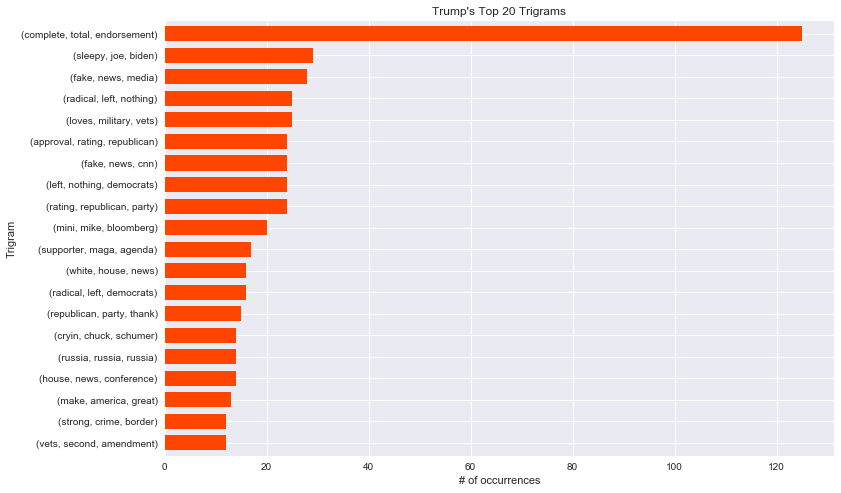

In [34]:
pd.Series(ngrams(trump_tokens, 3)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='orangered', width=.7, figsize=(12,8))
plt.title("Trump's Top 20 Trigrams")
plt.ylabel('Trigram')
plt.xlabel('# of occurrences')
trump_trigrams.most_common(NUM_NGRAMS)

[(('beat', 'donald', 'trump'), 41),
 (('battle', 'soul', 'nation'), 31),
 (('trump', 'white', 'house'), 21),
 (('defeat', 'donald', 'trump'), 21),
 (('health', 'care', 'workers'), 20),
 (('keep', 'momentum', 'going'), 20),
 (('gun', 'violence', 'epidemic'), 18),
 (('end', 'gun', 'violence'), 17),
 (('donald', 'trump', 'white'), 17),
 (('four', 'years', 'donald'), 16),
 (('make', 'voice', 'heard'), 16),
 (('tune', 'watch', 'live'), 16),
 (('every', 'single', 'day'), 15),
 (('get', 'white', 'house'), 14),
 (('front', 'lines', 'crisis'), 14),
 (('restore', 'soul', 'nation'), 14),
 (('years', 'donald', 'trump'), 13),
 (('public', 'health', 'crisis'), 13),
 (('front', 'lines', 'fight'), 13),
 (('get', 'donald', 'trump'), 13)]

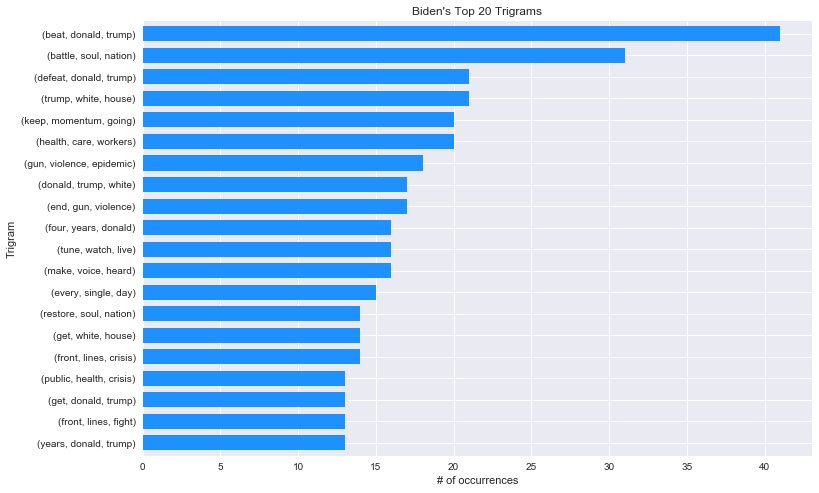

In [35]:
pd.Series(ngrams(biden_tokens, 3)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='dodgerblue', width=.7, figsize=(12,8))
plt.title("Biden's Top 20 Trigrams")
plt.ylabel('Trigram')
plt.xlabel('# of occurrences')
biden_trigrams.most_common(NUM_NGRAMS)

### 4-5 grams

[(('approval', 'rating', 'republican', 'party'), 24),
 (('radical', 'left', 'nothing', 'democrats'), 22),
 (('rating', 'republican', 'party', 'thank'), 14),
 (('white', 'house', 'news', 'conference'), 14),
 (('approval', 'rating', 'republican', 'party', 'thank'), 14),
 (('complete', 'total', 'endorsement', 'congressman'), 11),
 (('military', 'vets', 'second', 'amendment'), 10),
 (('white', 'house', 'press', 'conference'), 10),
 (('complete', 'total', 'endorsement', 'vote'), 10),
 (('loves', 'military', 'vets', 'strong'), 8),
 (('supporter', 'maga', 'agenda', 'strong'), 7),
 (('fake', 'news', 'lamestream', 'media'), 7),
 (('mike', 'complete', 'total', 'endorsement'), 7),
 (('house', 'press', 'conference', 'today'), 7),
 (('white', 'house', 'press', 'conference', 'today'), 7),
 (('fake', 'news', 'cnn', 'msdnc'), 6),
 (('failing', 'new', 'york', 'times'), 6),
 (('crime', 'border', 'second', 'amendment'), 6),
 (('totally', 'partisan', 'impeachment', 'hoax'), 6),
 (('strong', 'crime', 'mili

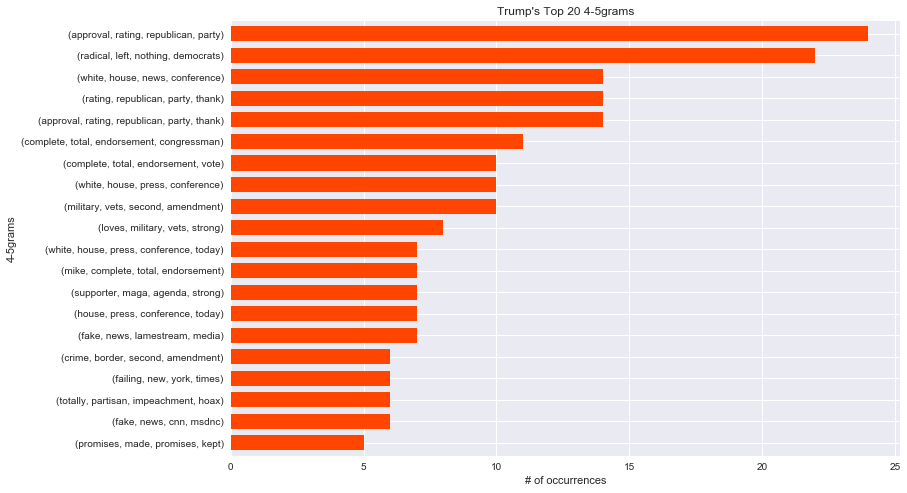

In [36]:
pd.Series(everygrams(trump_tokens, min_len= 4, max_len=5)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='orangered', width=.7, figsize=(12,8))
plt.title("Trump's Top 20 4-5grams")
plt.ylabel('4-5grams')
plt.xlabel('# of occurrences')

trump_4_5_grams = FreqDist(everygrams(trump_tokens, min_len= 4, max_len=5))
trump_4_5_grams.most_common(NUM_NGRAMS)

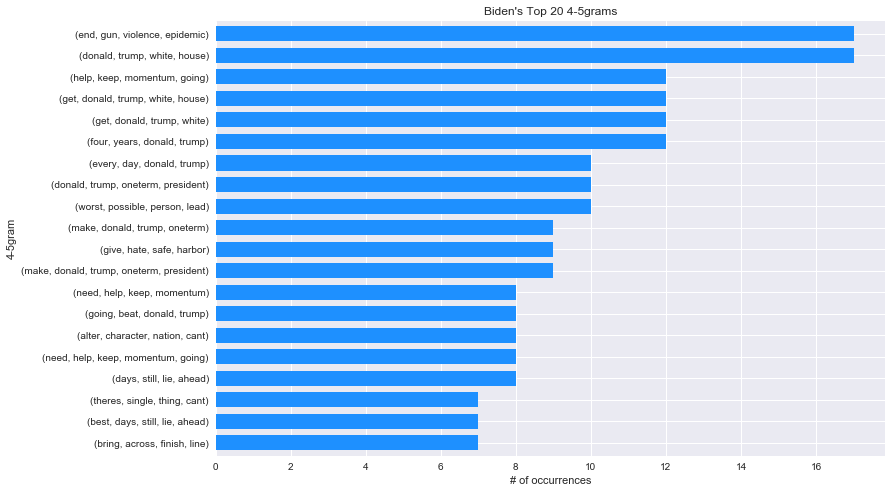

In [37]:
pd.Series(everygrams(biden_tokens, min_len= 4, max_len=5)).value_counts()[:NUM_NGRAMS].sort_values().plot.barh(color='dodgerblue', width=.7, figsize=(12,8))
plt.title("Biden's Top 20 4-5grams")
plt.ylabel('4-5gram')
plt.xlabel('# of occurrences')

biden_4_5_grams = FreqDist(everygrams(biden_tokens, min_len= 4, max_len=5)).most_common(NUM_NGRAMS)

From the above n-grams, it seems that Biden talks a lot about gun violence, healthcare, and climate change, while Trump talks a lot about fake news, whitehouse conferences, endorsements and republican party ratings. They also both mention each other a lot. Question is, how much? 

## How many times do they mention each other?

In [38]:
trump_tweets_contain_biden = trump_df[trump_df['text'].str.lower().str.contains("joe|biden")]
print(len(trump_tweets_contain_biden), "Trump tweets mention Joe Biden.")
trump_mention_biden_percent = round(100 * len(trump_tweets_contain_biden)/ len(trump_df), 2)
print("That means", trump_mention_biden_percent,  "% of Trump tweets mention Joe Biden")

177 Trump tweets mention Joe Biden.
That means 6.66 % of Trump tweets mention Joe Biden


In [39]:
biden_tweets_contain_trump = biden_df[biden_df['text'].str.lower().str.contains("trump|donald")]
print(len(biden_tweets_contain_trump), "Biden tweets mention Donald Trump.")
biden_mention_trump_percent = round(100 * len(biden_tweets_contain_trump)/ len(biden_df), 2)
print("That means", biden_mention_trump_percent,  "% of Biden tweets mention Donald Trump")

555 Biden tweets mention Donald Trump.
That means 30.56 % of Biden tweets mention Donald Trump


## How many times do they mention the coronavirus? 

In [40]:
corona_regex = "covid|corona|virus|pandemic"
biden_tweets_relate_corona = biden_df[biden_df['text'].str.lower().str.contains(corona_regex)]
print(len(biden_tweets_relate_corona))
biden_tweets_relate_corona_percent = round(100 * len(biden_tweets_relate_corona)/ len(biden_df), 2)
print("That means", biden_tweets_relate_corona_percent,  "% of Biden tweets mention coronavirus")

246
That means 13.55 % of Biden tweets mention coronavirus


In [41]:
trump_tweets_relate_corona = trump_df[trump_df['text'].str.lower().str.contains(corona_regex)]
print(len(trump_tweets_relate_corona))
trump_tweets_relate_corona_percent = round(100 * len(trump_tweets_relate_corona)/ len(trump_df), 2)
print("That means", trump_tweets_relate_corona_percent,  "% of Trump tweets mention coronavirus")

174
That means 6.55 % of Trump tweets mention coronavirus


Biden tweets about the coronavirus nearly twice as much as Trump. Also while only ~7% of Trump tweets mention Joe Biden, nearly 31% of Biden tweets mention Trump.

# How frequently do they tweet? Has the frequency of tweets changed as the pandemic evolved?

### Trump

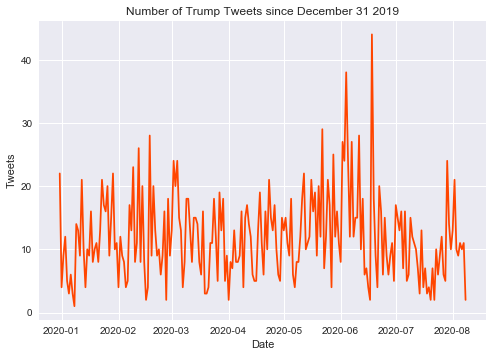

In [42]:
trump_tweet_by_date = trump_df.groupby(by=trump_df['created_at'].dt.date).count()['text']
plt.plot(trump_tweet_by_date.index.values, trump_tweet_by_date, color='orangered')
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.title('Number of Trump Tweets since December 31 2019')
plt.show()

### Biden

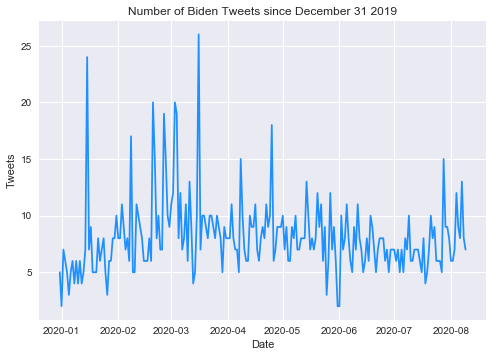

In [43]:
biden_tweet_by_date = biden_df.groupby(by=biden_df['created_at'].dt.date).count()['text']
plt.plot(biden_tweet_by_date.index.values, biden_tweet_by_date, color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.title('Number of Biden Tweets since December 31 2019')
plt.show()

### Both candidates on the same figure

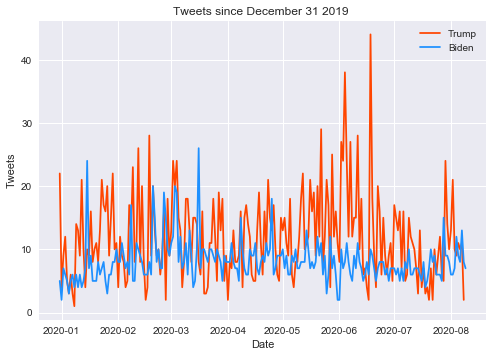

In [44]:
plt.plot(trump_tweet_by_date.index.values, trump_tweet_by_date, 'orangered')
plt.plot(biden_tweet_by_date.index.values, biden_tweet_by_date, 'dodgerblue')
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.title('Tweets since December 31 2019 ')
plt.legend(['Trump', 'Biden'])
plt.show()

From the graphs above, it seems that there are peaks and valleys. Future work would be to investigate the dates with more tweets than normal to see if those are linked with news events. Moreover, the variance in the number of tweets brings up the question if they tweet more on certain days over others?

## Do they prefer to tweet on certain days over others?

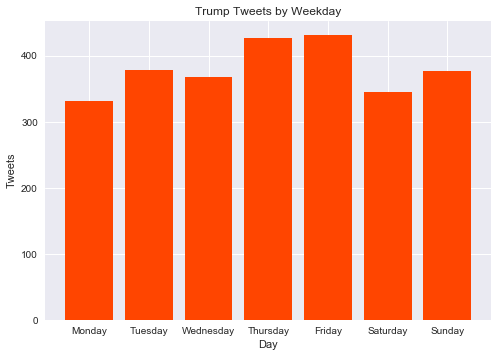

In [45]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

trump_tweets_by_weekday = trump_df.groupby(by=trump_df['created_at'].dt.day_name()).count().reindex(weekdays)['text']
plt.bar(trump_tweets_by_weekday.index.values, trump_tweets_by_weekday, color='orangered')
plt.xlabel('Day')
plt.ylabel('Tweets')
plt.title('Trump Tweets by Weekday')
plt.show()

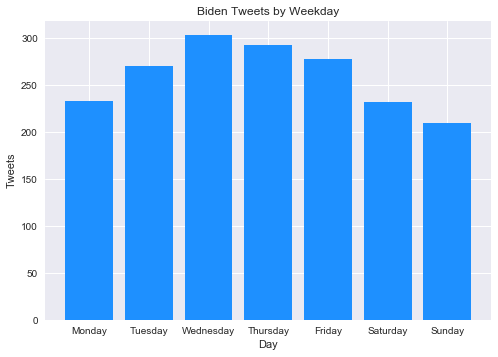

In [46]:
biden_tweets_by_weekday = biden_df.groupby(by=biden_df['created_at'].dt.day_name()).count().reindex(weekdays)['text']
plt.bar(biden_tweets_by_weekday.index.values, biden_tweets_by_weekday, color='dodgerblue')
plt.xlabel('Day')
plt.ylabel('Tweets')
plt.title('Biden Tweets by Weekday')
plt.show()

It seems that Biden tends to tweet most during the middle of the week and tapers off on the weekend. Whereas Trump tends to tweet consistently with a tendency to tweet more on Thursdays and Fridays.

# 5. Sentiment Analysis<a class="anchor" id="sentiment_analysis">

## Get polarity and subjectivity scores for candidate tweets

In [47]:
# Measure subjectivity of a text. Subjectivity is in the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Use polarity as a measure for sentiment. Polarity is in the range [-1.0, 1.0] where -1 is negative and +1 is positive sentiment
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [48]:
trump_df['Subjectivity'] = trump_df['clean_text'].apply(get_subjectivity)
trump_df['Polarity'] = trump_df['clean_text'].apply(get_polarity)

biden_df['Subjectivity'] = biden_df['clean_text'].apply(get_subjectivity)
biden_df['Polarity'] = biden_df['clean_text'].apply(get_polarity)

In [49]:
print(trump_df['Polarity'])
print(trump_df['Subjectivity'])

12      0.031250
13      0.000000
21      0.253333
22      0.269924
23      0.154762
          ...   
7028    0.087714
7029    0.588889
7030    0.164444
7031    0.186667
7032    0.008333
Name: Polarity, Length: 2657, dtype: float64
12      0.250000
13      0.050000
21      0.423333
22      0.441970
23      0.253968
          ...   
7028    0.219429
7029    0.729167
7030    0.380000
7031    0.356667
7032    0.425000
Name: Subjectivity, Length: 2657, dtype: float64


## Assign positive, neutral, and negative labels to tweets based on polarity

In [50]:
def get_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [51]:
trump_df['Sentiment'] = trump_df['Polarity'].apply(get_sentiment)
biden_df['Sentiment'] = biden_df['Polarity'].apply(get_sentiment)

In [52]:
trump_df['Sentiment']

12      Positive
13       Neutral
21      Positive
22      Positive
23      Positive
          ...   
7028    Positive
7029    Positive
7030    Positive
7031    Positive
7032    Positive
Name: Sentiment, Length: 2657, dtype: object

## Most Positive and Negative Tweets

### Trump

In [53]:
trump_most_positive = trump_df.nlargest(10, 'Polarity')
print("Trump's top", len(trump_most_positive), "most positive tweets" )

for idx, tweet in enumerate(trump_most_positive['text']):
    print(idx, tweet)
    print()

Trump's top 10 most positive tweets
0 Two wonderful people! https://t.co/Fo2CLjc9YZ

1 I built the greatest economy in the World the best the U.S. has ever had. I am doing it again!

2 ...AND THE BEST IS YET TO COME!

3 The Democrat’s Best &amp; Finest! https://t.co/xAmbP1Nnm0

4 ....We have the greatest healthcare system experts scientists and doctors anywhere in the world. Together we will PREVAIL!

5 THE BEST IS YET TO COME! https://t.co/C0RicMRP0Z

6 “An investigation into NOTHING.” The wonderful @trish_regan on the Mueller Witch Hunt!

7 ....for the wonderful job he has done and we look forward to working with him closely perhaps in another capacity within the Administration!

8 Congratulations to Eddie DeBartolo Jr. and your wonderful family of friends! https://t.co/IJu93xjiQS

9 BEST USA ECONOMY IN HISTORY!



In [54]:
trump_most_negative = trump_df.nsmallest(10, 'Polarity')
print("Trump's top", len(trump_most_negative), "most negative tweets" )

for idx, tweet in enumerate(trump_most_negative['text']):
    print(idx, tweet)
    print()

Trump's top 10 most negative tweets
0 This is outrageous. Must be met with immediate litigation! @GOPChairwoman https://t.co/CD6bD3Kn6J

1 ....are getting caught doing very evil things and Republicans should take note. This was grave misconduct by the Obama Justice Department! @GovChristie

2 “Sotomayor accuses GOP appointed Justices  of being biased in favor of Trump.” @IngrahamAngle @FoxNews  This is a terrible thing to say. Trying to “shame” some into voting her way? She never criticized Justice Ginsberg when she called me a “faker”. Both should recuse themselves..

3 Don Lemon the dumbest man on television (with terrible ratings!). https://t.co/iQXCc7lvCt

4 A very bad night for Mini Mike!

5 ....The reason for this is that the Do Nothing Democrats using disinformation Hoax number 7 don’t want Bernie Sanders to get the Democrat Nomination and they figure this would be very bad for his chances. It’s all rigged again against Crazy Bernie Sanders!

6 Another Fake Whistleblower. Republ

### Biden

In [55]:
biden_most_positive = biden_df.nlargest(10, 'Polarity')
print("Biden's top", len(biden_most_positive), "most positive tweets" )

for idx, tweet in enumerate(biden_most_positive['text']):
    print(idx, tweet)
    print()

Biden's top 10 most positive tweets
0 The health care workers on the frontlines of this fight are some of the greatest heroes our nation has ever seen. https://t.co/Ry6TvJcbuU

1 It’s in some of our darkest moments of despair that we’ve made some of our greatest progress. If we stand together, as one America, we'll rise stronger than before. https://t.co/buzkmkM1Gf

2 It’s in some of our darkest moments of despair that we’ve made some of our greatest progress — and we have that chance once again. We’re not just going to rebuild this nation — we’re going to transform it. 

There is nothing we can’t do if we do it together. https://t.co/iozMdaLtAw

3 Make no mistake: I believe our best days still lie ahead. We can and will transform this nation — together.

4 As Muslim families across America and around the world celebrate the beginning of Ramadan, @DrBiden and I want to extend our best wishes to all who are observing this holy month. Ramadan Mubarak. https://t.co/mhKD5YSN85

5 This is a

In [56]:
biden_most_negative = biden_df.nsmallest(10, 'Polarity')
print("Biden's top", len(biden_most_negative), "most negative tweets" )

for idx, tweet in enumerate(biden_most_negative['text']):
    print(idx, tweet)
    print()

Biden's top 10 most negative tweets
0 Families across the country are impacted by COVID-19—and it can be especially difficult to explain to children. 

Jill and I spoke with ItsJudysLife, JHouseVlogs and The Curly Coopers to answer their questions about the crisis. Tune in on Sunday at 7PM ET: https://t.co/xk0GcS7PGq https://t.co/TUQnhOroTU

1 34 U.S. troops have been diagnosed with traumatic brain injury after Iranian missiles struck their base in Iraq. Donald Trump brought us to the brink of war—then dismissed the injuries as “headaches.”

The idea that the commander in chief would take this lightly is disgusting. https://t.co/Cn8Bb7KLy4

2 We’re building a campaign powered by the backbone and the base of the Democratic party. A campaign that will defeat Donald Trump and restore the soul of this nation. Join us: https://t.co/gnaFCACYrW

3 Donald Trump's "Remain in Mexico" policy is dangerous, inhumane, and goes against everything we stand for as a nation of immigrants. My administrat

## Visualize Sentiment Analysis

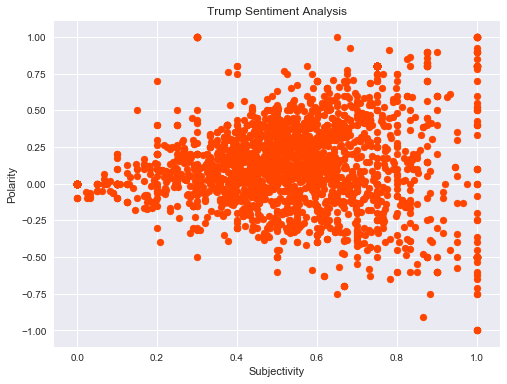

In [57]:
plt.figure(figsize=(8,6)) 
plt.scatter(trump_df["Subjectivity"], trump_df["Polarity"], color='orangered')            
plt.title('Trump Sentiment Analysis') 
plt.xlabel('Subjectivity') 
plt.ylabel('Polarity') 
plt.show()

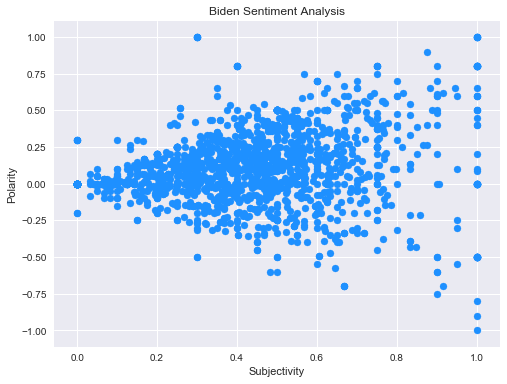

In [58]:
plt.figure(figsize=(8,6)) 
plt.scatter(biden_df["Subjectivity"], biden_df["Polarity"], color='dodgerblue') 

plt.title('Biden Sentiment Analysis') 
plt.xlabel('Subjectivity') 
plt.ylabel('Polarity') 
plt.show()

### View the counts of positive, netural, and negative tweets

In [59]:
trump_df['Sentiment'].value_counts()

Positive    1580
Negative     658
Neutral      419
Name: Sentiment, dtype: int64

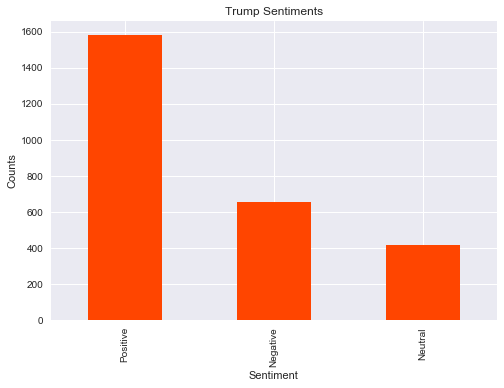

In [60]:
plt.title('Trump Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
trump_df['Sentiment'].value_counts().plot(kind = 'bar', color='orangered')
plt.show()

In [61]:
biden_df['Sentiment'].value_counts()

Positive    995
Neutral     417
Negative    404
Name: Sentiment, dtype: int64

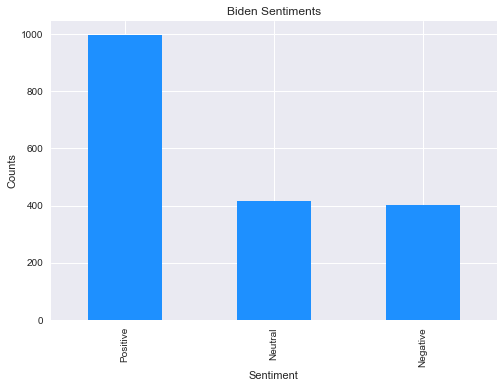

In [62]:
plt.title('Biden Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
biden_df['Sentiment'].value_counts().plot(kind = 'bar', color='dodgerblue')
plt.show()

## Percentage of positive/negative tweets of each candidate

### Trump

In [63]:
positive_trump_tweets = trump_df[trump_df.Sentiment == 'Positive']
positive_trump_percent = round(len(positive_trump_tweets) / len(trump_df) * 100, 2)
print(positive_trump_percent, '% of trump tweets are positive.')

59.47 % of trump tweets are positive.


In [64]:
# Get % of trump tweets that are neutral
neutral_trump_tweets = trump_df[trump_df.Sentiment == 'Neutral']
neutral_trump_percent = round(len(neutral_trump_tweets) / len(trump_df) * 100, 2)
print(neutral_trump_percent,'% of trump tweets are neutral.')

15.77 % of trump tweets are neutral.


In [65]:
negative_trump_tweets = trump_df[trump_df.Sentiment == 'Negative']
negative_trump_percent = round(len(negative_trump_tweets) / len(trump_df) * 100, 2)
print(negative_trump_percent, '% of trump tweets are negative.')

24.76 % of trump tweets are negative.


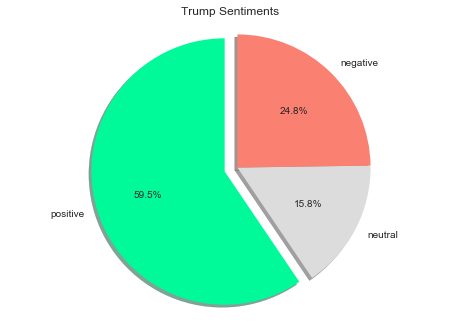

In [66]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sentiments = ['positive', 'neutral', 'negative']
percentages = [positive_trump_percent, neutral_trump_percent, negative_trump_percent]
explode = [0.1, 0, 0]

fig1, ax1 = plt.subplots()
pie_colors = ['mediumspringgreen', 'gainsboro', 'salmon']
ax1.pie(percentages, explode=explode, labels=sentiments, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=pie_colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Trump Sentiments")
plt.show()

### Biden

In [67]:
positive_biden_tweets = biden_df[biden_df.Sentiment == 'Positive']
positive_biden_percent = round(len(positive_biden_tweets) / len(biden_df) * 100, 2)
print(positive_biden_percent, '% of biden tweets are positive.')

54.79 % of biden tweets are positive.


In [68]:
neutral_biden_tweets = biden_df[biden_df.Sentiment == 'Neutral']
neutral_biden_percent = round(len(neutral_biden_tweets) / len(biden_df) * 100, 2)
print(neutral_biden_percent, '% of biden tweets are neutral.')

22.96 % of biden tweets are neutral.


In [69]:
negative_biden_tweets = biden_df[biden_df.Sentiment == 'Negative']
negative_biden_percent = round(len(negative_biden_tweets) / len(biden_df) * 100, 2)
print(negative_biden_percent, '% of biden tweets are negative.')

22.25 % of biden tweets are negative.


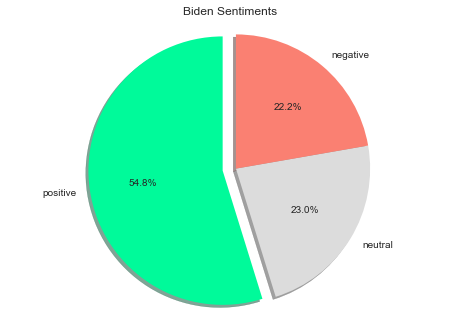

In [70]:
percentages = [positive_biden_percent, neutral_biden_percent, negative_biden_percent]

fig2, ax2 = plt.subplots()
ax2.pie(percentages, explode=explode, labels=sentiments, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=pie_colors)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Biden Sentiments")
plt.show()

As expected, Trump has a larger proportion of tweets that are perceived as positive (~60% positive compared to Biden's 54% positive). I suspect this is due to Trump's tendency to exaggerate with frequent use of words such as 'great', 'wonderful', etc. Additionally, a slightly larger portion of tweets are negative in comparison to Biden's.

## Did their sentiments change as the pandemic evolved?

### Trump

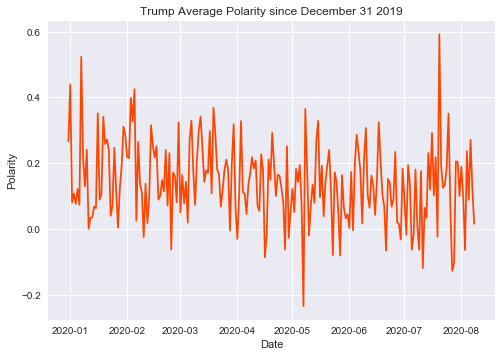

In [71]:
trump_polarity_by_date = trump_df.groupby(by=trump_df['created_at'].dt.date).mean()['Polarity']
plt.plot(trump_polarity_by_date.index.values, trump_polarity_by_date, color='orangered')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.title('Trump Average Polarity since December 31 2019')
plt.show()

### Biden

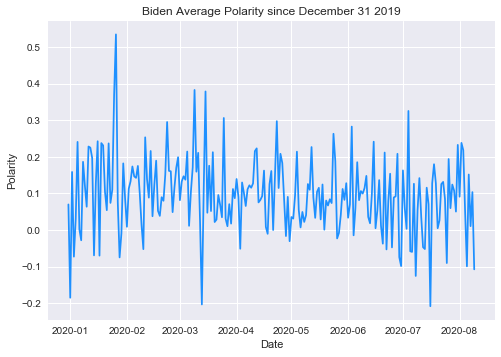

In [72]:
biden_polarity_by_date = biden_df.groupby(by=biden_df['created_at'].dt.date).mean()['Polarity']
plt.plot(biden_polarity_by_date.index.values, biden_polarity_by_date, color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.title('Biden Average Polarity since December 31 2019')
plt.show()

### Both on one plot

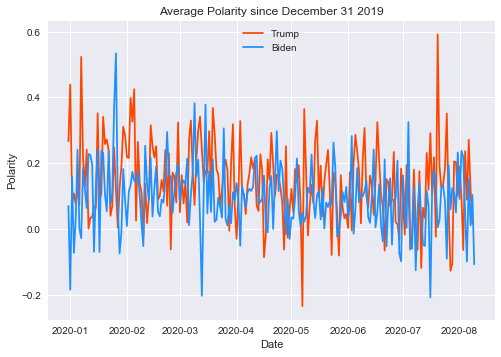

In [73]:
plt.plot(trump_polarity_by_date.index.values, trump_polarity_by_date, color='orangered')
plt.plot(biden_polarity_by_date.index.values, biden_polarity_by_date, color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.title('Average Polarity since December 31 2019')
plt.legend(['Trump', 'Biden'])
plt.show()

There doesn't seem to be any clear trend from the data. Future work could include investigating the dates and tweets with the largest peaks/valleys to see if those correlate with any coronavirus news events.

# 6. Topic Modeling with [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)<a class="anchor" id="topic_modeling">

# Peprocess data for topic modelling
Remove words with fewer than three characters, perform lemmatization and stemming, include additional stopwords to improve topic modelling. 

In [74]:
# Define functions for topic model preprocessing
custom_trump_stopwords = ['realdonaldtrump', 'great', 'pass']
def stem_and_lemmatize(text):
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(text))


def lda_processing(tokens):
    result = []
    for token in tokens:
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stem_and_lemmatize(token))
    return result

def trump_lda_processing(tokens):
    result = []
    for token in tokens:
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in custom_trump_stopwords:
            result.append(stem_and_lemmatize(token))
    return result

In [75]:
trump_df['processed_tokens'] = trump_df['tokens'].apply(trump_lda_processing)
biden_df['processed_tokens'] = biden_df['tokens'].apply(lda_processing)

Before preprocessing:

In [76]:
trump_df['tokens'].head(20)

12              [major, news, conference, ten, minutes]
13    [sleepy, joe, biden, agreed, radical, left, de...
21    [big, wins, tennessee, kansas, congratulations...
22    [news, conference, chinavirus, announced, good...
23    [3pm, afternoon, spoke, president, aoun, leban...
24    [conference, call, sunday, president, macron, ...
25    [lengthy, discussion, morning, president, macr...
26    [pelosi, schumer, interested, bailout, money, ...
29                               [great, jobs, numbers]
30    [yesterdays, statement, sleepy, joe, biden, lo...
32    [biggest, political, crime, scandal, american,...
43    [sleepy, joe, biden, lost, black, vote, statem...
44    [called, politicization, china, virus, radical...
46    [win, ohio, even, bigger, 2016, maga, stronger...
58    [like, radical, left, new, york, trying, destr...
61    [joe, biden, unlike, african, american, commun...
62                       [departed, great, state, ohio]
64    [upon, departing, oval, office, ohio, ive,

After preprocessing:

In [77]:
trump_df['processed_tokens'].head(20)

12                         [major, news, confer, minut]
13    [sleepi, biden, agre, radic, left, democrat, r...
21    [win, tennesse, kansa, congratul, billhagertyt...
22    [news, confer, chinaviru, announc, good, econo...
23    [afternoon, spoke, presid, aoun, lebanon, info...
24    [confer, sunday, presid, macron, leader, leban...
25    [lengthi, discuss, morn, presid, macron, franc...
26    [pelosi, schumer, interest, bailout, money, po...
29                                        [job, number]
30    [yesterday, statement, sleepi, biden, longer, ...
32    [biggest, polit, crime, scandal, american, his...
43    [sleepi, biden, lost, black, vote, statement, ...
44    [call, politic, china, viru, radic, left, demo...
46                 [ohio, bigger, 2016, maga, stronger]
58    [like, radic, left, york, tri, destroy, biden,...
61    [biden, unlik, african, american, commun, lati...
62                                [depart, state, ohio]
64    [depart, oval, offic, ohio, notifi, staff,

In [78]:
trump_processed_tokens = trump_df['processed_tokens']
biden_processed_tokens = biden_df['processed_tokens']

## Create bags of words on the datasets

In [79]:
trump_dictionary = gensim.corpora.Dictionary(trump_processed_tokens)
biden_dictionary = gensim.corpora.Dictionary(biden_processed_tokens)

In [80]:
print("Number of words in Trump dictionary:", len(trump_dictionary))
print("Number of words in Biden dictionary:", len(biden_dictionary))

Number of words in Trump dictionary: 4900
Number of words in Biden dictionary: 3269


In [81]:
# Filter out tokens that appear in less than 10 tweets or more than half the tweets
trump_dictionary.filter_extremes(no_below=10, no_above=0.5)
biden_dictionary.filter_extremes(no_below=10, no_above=0.5)

In [82]:
print("Number of words in Trump dictionary after filtering extremes:", len(trump_dictionary))
print("Number of words in Biden dictionary after filtering extremes:", len(biden_dictionary))

Number of words in Trump dictionary after filtering extremes: 717
Number of words in Biden dictionary after filtering extremes: 546


In [83]:
trump_bow_corpus = [trump_dictionary.doc2bow(tweet) for tweet in trump_processed_tokens]
biden_bow_corpus = [biden_dictionary.doc2bow(tweet) for tweet in biden_processed_tokens]

## Improve bag of words with TF-IDF
We can perform topic modelling directly with our bag of words, but we can further improve it first by incorporating [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). 

In [84]:
trump_tfidf = models.TfidfModel(trump_bow_corpus)
biden_tfidf = models.TfidfModel(biden_bow_corpus)

trump_tfidf_corpus = trump_tfidf[trump_bow_corpus]
biden_tfidf_corpus = biden_tfidf[biden_bow_corpus]

## Train the LDA models with different number of clusters

In [85]:
NUM_WORKERS = 3
NUM_PASSES = 15
trump_lda_3 = gensim.models.LdaMulticore(trump_tfidf_corpus, num_topics=3, id2word=trump_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
trump_lda_3.save('trump_lda/trump_lda_3.gensim')

In [86]:
trump_lda_5 = gensim.models.LdaMulticore(trump_tfidf_corpus, num_topics=5, id2word=trump_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
trump_lda_5.save('trump_lda/trump_lda_5.gensim')

In [87]:
trump_lda_7 = gensim.models.LdaMulticore(trump_tfidf_corpus, num_topics=7, id2word=trump_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
trump_lda_7.save('trump_lda/trump_lda_7.gensim')

In [88]:
trump_lda_10 = gensim.models.LdaMulticore(trump_tfidf_corpus, num_topics=10, id2word=trump_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
trump_lda_10.save('trump_lda/trump_lda_10.gensim')

In [89]:
biden_lda_3 = gensim.models.LdaMulticore(biden_tfidf_corpus, num_topics=3, id2word=biden_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
biden_lda_3.save('biden_lda/biden_lda_3.gensim')

In [90]:
biden_lda_5 = gensim.models.LdaMulticore(biden_tfidf_corpus, num_topics=5, id2word=biden_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
biden_lda_5.save('biden_lda/biden_lda_5.gensim')

In [91]:
biden_lda_7 = gensim.models.LdaMulticore(biden_tfidf_corpus, num_topics=7, id2word=biden_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
biden_lda_7.save('biden_lda/biden_lda_7.gensim')

In [92]:
biden_lda_10 = gensim.models.LdaMulticore(biden_tfidf_corpus, num_topics=10, id2word=biden_dictionary, passes=NUM_PASSES, workers=NUM_WORKERS)
biden_lda_10.save('biden_lda/biden_lda_10.gensim')

## Look at words in each topic with their relative weights

### Trump

In [93]:
for idx, topic in trump_lda_5.print_topics(num_words=7):
    print("Topic %d:" %idx, topic)

Topic 0: 0.016*"fake" + 0.015*"news" + 0.013*"vote" + 0.011*"book" + 0.011*"elect" + 0.010*"hard" + 0.010*"democrat"
Topic 1: 0.045*"thank" + 0.016*"foxnew" + 0.010*"interview" + 0.009*"impeach" + 0.009*"poll" + 0.008*"foxandfriend" + 0.008*"watch"
Topic 2: 0.017*"complet" + 0.017*"endors" + 0.015*"total" + 0.013*"confer" + 0.013*"hous" + 0.013*"white" + 0.013*"militari"
Topic 3: 0.014*"countri" + 0.014*"rate" + 0.013*"test" + 0.012*"approv" + 0.011*"coronaviru" + 0.011*"parti" + 0.011*"republican"
Topic 4: 0.009*"democrat" + 0.009*"berni" + 0.009*"mike" + 0.008*"mini" + 0.008*"time" + 0.008*"year" + 0.008*"russia"


### Biden

In [94]:
for idx, topic in biden_lda_5.print_topics(num_words=7):
    print("Topic %d:" %idx, topic)

Topic 0: 0.021*"presid" + 0.016*"health" + 0.015*"need" + 0.013*"trump" + 0.012*"care" + 0.011*"donald" + 0.011*"leadership"
Topic 1: 0.015*"tune" + 0.014*"join" + 0.011*"campaign" + 0.010*"million" + 0.010*"covid19" + 0.010*"help" + 0.010*"defeat"
Topic 2: 0.014*"donald" + 0.014*"trump" + 0.013*"respons" + 0.012*"hous" + 0.011*"futur" + 0.011*"test" + 0.011*"america"
Topic 3: 0.014*"presid" + 0.011*"deserv" + 0.010*"famili" + 0.010*"mask" + 0.010*"trump" + 0.010*"peopl" + 0.010*"work"
Topic 4: 0.019*"thank" + 0.016*"soul" + 0.015*"line" + 0.014*"today" + 0.014*"vote" + 0.013*"nation" + 0.013*"worker"


## Test models on a new unseen tweet

### Trump

In [95]:
unseen_trump_tweet = 'Big China Virus breakouts all over the World, including nations which were thought to have done a great job. The Fake News doesn’t report this. USA will be stronger than ever before, and soon!'
trump_bow_vector = trump_dictionary.doc2bow(trump_lda_processing(basic_processing(unseen_trump_tweet)))

for index, score in sorted(trump_lda_5[trump_bow_vector], key=lambda t: t[1], reverse=True):
    print("Score: {}\t Topic: {}".format(score, trump_lda_5.print_topic(index, topn=5)))

Score: 0.9370603561401367	 Topic: 0.014*"countri" + 0.014*"rate" + 0.013*"test" + 0.012*"approv" + 0.011*"coronaviru"
Score: 0.016022542491555214	 Topic: 0.009*"democrat" + 0.009*"berni" + 0.009*"mike" + 0.008*"mini" + 0.008*"time"
Score: 0.015734048560261726	 Topic: 0.045*"thank" + 0.016*"foxnew" + 0.010*"interview" + 0.009*"impeach" + 0.009*"poll"
Score: 0.015725571662187576	 Topic: 0.016*"fake" + 0.015*"news" + 0.013*"vote" + 0.011*"book" + 0.011*"elect"
Score: 0.015457440167665482	 Topic: 0.017*"complet" + 0.017*"endors" + 0.015*"total" + 0.013*"confer" + 0.013*"hous"


### Biden

In [96]:
unseen_biden_tweet = 'Our planet can’t take four more years of Donald Trump. We have to get him out of the White House so we can start treating the climate crisis like the urgent threat it is.'
biden_bow_vector = biden_dictionary.doc2bow(lda_processing(basic_processing(unseen_biden_tweet)))

for index, score in sorted(biden_lda_5[biden_bow_vector], key=lambda t: t[1], reverse=True):
    print("Score: {}\t Topic: {}".format(score, biden_lda_5.print_topic(index, topn=5)))

Score: 0.9377828240394592	 Topic: 0.014*"donald" + 0.014*"trump" + 0.013*"respons" + 0.012*"hous" + 0.011*"futur"
Score: 0.01565626822412014	 Topic: 0.021*"presid" + 0.016*"health" + 0.015*"need" + 0.013*"trump" + 0.012*"care"
Score: 0.01554274745285511	 Topic: 0.019*"thank" + 0.016*"soul" + 0.015*"line" + 0.014*"today" + 0.014*"vote"
Score: 0.015526152215898037	 Topic: 0.014*"presid" + 0.011*"deserv" + 0.010*"famili" + 0.010*"mask" + 0.010*"trump"
Score: 0.01549206580966711	 Topic: 0.015*"tune" + 0.014*"join" + 0.011*"campaign" + 0.010*"million" + 0.010*"covid19"


## Visualize topics

### 5 Topics

#### Trump

In [97]:
pyLDAvis.enable_notebook()

trump_lda5_display = pyLDAvis.gensim.prepare(topic_model=trump_lda_5, corpus=trump_tfidf_corpus, dictionary=trump_dictionary)
trump_lda5_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.052819 -0.027003       1        1  24.031704
3      0.035447 -0.144489       2        1  20.989885
2     -0.163400  0.043561       3        1  20.570910
1      0.120776  0.117203       4        1  17.858980
0     -0.045641  0.010726       5        1  16.548523, topic_info=        Term       Freq      Total Category  logprob  loglift
223    thank  96.000000  96.000000  Default  30.0000  30.0000
21    endors  30.000000  30.000000  Default  29.0000  29.0000
17   complet  31.000000  31.000000  Default  28.0000  28.0000
0     confer  20.000000  20.000000  Default  27.0000  27.0000
263     test  21.000000  21.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
70      come   7.577070  26.109264   Topic5  -5.0509   0.5617
223    thank   9.633855  96.660156   Topic5  -4.8107  -0.5070
37    number   7.151306  25.901133   Topic5  -5.1087   0.5119
404      dem   6.759866  17.984894   Topic5  -5.1650   0.8203
28     total   6.661772  38.462440   Topic5  -5.1796   0.0456

[304 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
386       2  0.185172    2020
386       5  0.740687    2020
478       4  0.180356  accord
478       5  0.721426  accord
653       2  0.923023     act
...     ...       ...     ...
182       1  0.461371    year
182       2  0.141960    year
182       3  0.070980    year
182       4  0.212940    year
182       5  0.106470    year

[652 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 1])

#### Biden

In [98]:
biden_lda5_display = pyLDAvis.gensim.prepare(topic_model=biden_lda_5, corpus=biden_tfidf_corpus, dictionary=biden_dictionary)
biden_lda5_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.091420 -0.048230       1        1  24.110123
2      0.053116 -0.070672       2        1  21.645325
1     -0.038152  0.130411       3        1  18.691097
4     -0.173110 -0.057983       4        1  18.668806
3      0.066725  0.046474       5        1  16.884651, topic_info=       Term       Freq      Total Category  logprob  loglift
288    soul  16.000000  16.000000  Default  30.0000  30.0000
317   thank  24.000000  24.000000  Default  29.0000  29.0000
493    line  15.000000  15.000000  Default  28.0000  28.0000
385    tune  21.000000  21.000000  Default  27.0000  27.0000
310    head  13.000000  13.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
159    said   5.438383  13.979577   Topic5  -5.0947   0.8346
62     know   5.903739  24.734802   Topic5  -5.0126   0.3461
206    need   6.481309  51.970444   Topic5  -4.9192  -0.3030
0    donald   6.305285  51.435596   Topic5  -4.9468  -0.3202
162   fight   5.470604  23.116886   Topic5  -5.0888   0.3376

[301 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
333       5  0.660822      accept
414       2  0.840344  accomplish
502       2  0.935500     account
387       1  0.164404      actual
387       3  0.164404      actual
...     ...       ...         ...
13        2  0.351986        year
13        3  0.117329        year
13        4  0.078219        year
13        5  0.312876        year
281       3  0.799495       young

[597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

### 7 Topics

#### Trump

In [99]:
trump_lda7_display = pyLDAvis.gensim.prepare(topic_model=trump_lda_7, corpus=trump_tfidf_corpus, dictionary=trump_dictionary)
trump_lda7_display


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.020670 -0.110553       1        1  17.432091
4     -0.191251 -0.021345       2        1  16.809635
5      0.141939 -0.080765       3        1  15.985706
2      0.061807  0.024472       4        1  15.251676
6     -0.071428 -0.017107       5        1  12.733096
1      0.001675  0.016601       6        1  11.148083
0      0.036589  0.188698       7        1  10.639713, topic_info=         Term       Freq      Total Category  logprob  loglift
223     thank  97.000000  97.000000  Default  30.0000  30.0000
2        news  52.000000  52.000000  Default  29.0000  29.0000
82       fake  46.000000  46.000000  Default  28.0000  28.0000
21     endors  30.000000  30.000000  Default  27.0000  27.0000
17    complet  31.000000  31.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
251     crazi   5.025438  16.335361   Topic7  -5.0198   1.0618
266      deal   5.079212  17.818781   Topic7  -5.0091   0.9855
25      state   5.133996  43.485062   Topic7  -4.9984   0.1040
5    democrat   5.047768  43.011646   Topic7  -5.0153   0.0981
267      look   4.871823  26.433594   Topic7  -5.0508   0.5494

[375 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
386       2  0.088588       2020
386       5  0.088588       2020
386       6  0.797288       2020
478       4  0.882855     accord
186       1  0.133620  administr
...     ...       ...        ...
182       3  0.142514       year
182       4  0.391913       year
182       5  0.106885       year
182       6  0.035628       year
182       7  0.071257       year

[953 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 3, 7, 2, 1])

#### Biden

In [100]:
biden_lda7_display = pyLDAvis.gensim.prepare(topic_model=biden_lda_7, corpus=biden_tfidf_corpus, dictionary=biden_dictionary)
biden_lda7_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.069106  0.001223       1        1  19.052691
1      0.119207 -0.052805       2        1  15.609315
6     -0.088066  0.028680       3        1  13.628395
3      0.085008  0.042574       4        1  13.318001
4      0.087481 -0.103471       5        1  13.027657
0     -0.152844 -0.074795       6        1  12.683916
2      0.018321  0.158594       7        1  12.680021, topic_info=        Term       Freq      Total Category  logprob  loglift
302     care  29.000000  29.000000  Default  30.0000  30.0000
148     test  20.000000  20.000000  Default  29.0000  29.0000
75    health  30.000000  30.000000  Default  28.0000  28.0000
317    thank  25.000000  25.000000  Default  27.0000  27.0000
163   listen  15.000000  15.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
206     need   9.402876  52.567627   Topic7  -4.2608   0.3441
2      trump   7.446292  55.928047   Topic7  -4.4941   0.0488
0     donald   7.207457  51.345177   Topic7  -4.5267   0.1017
44      time   6.560881  34.466225   Topic7  -4.6206   0.4063
69   countri   5.278059  34.312553   Topic7  -4.8382   0.1932

[389 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
404       2  0.201854      access
404       5  0.706489      access
414       1  0.879000  accomplish
502       1  0.313845     account
502       2  0.627690     account
...     ...       ...         ...
13        2  0.038997        year
13        3  0.116991        year
13        4  0.116991        year
13        6  0.077994        year
13        7  0.467964        year

[962 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 4, 5, 1, 3])

### 10 topics

#### Trump

In [101]:
trump_lda10_display = pyLDAvis.gensim.prepare(topic_model=trump_lda_10, corpus=trump_tfidf_corpus, dictionary=trump_dictionary)
trump_lda10_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.080717  0.061145       1        1  14.319653
6     -0.016207  0.027539       2        1  12.491572
9     -0.251999 -0.060762       3        1  11.704863
5     -0.055368  0.062969       4        1  10.672611
4     -0.001444 -0.037088       5        1  10.009552
0      0.080539 -0.067259       6        1   9.218324
3      0.114488  0.028880       7        1   8.474259
7     -0.035369  0.192630       8        1   8.080132
2      0.006898 -0.123229       9        1   7.677732
8      0.077743 -0.084824      10        1   7.351298, topic_info=        Term       Freq      Total Category  logprob  loglift
223    thank  94.000000  94.000000  Default  30.0000  30.0000
506    white  23.000000  23.000000  Default  29.0000  29.0000
17   complet  30.000000  30.000000  Default  28.0000  28.0000
21    endors  29.000000  29.000000  Default  27.0000  27.0000
0     confer  20.000000  20.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
62       job   5.151055  17.047340  Topic10  -4.6254   1.4135
262     poll   4.679607  18.665478  Topic10  -4.7214   1.2268
155    trump   4.817562  30.859093  Topic10  -4.6923   0.7531
160     time   4.826293  31.253216  Topic10  -4.6905   0.7422
4      biden   3.644255  25.242191  Topic10  -4.9714   0.6749

[487 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
386       3  0.088414  2020
386       5  0.265242  2020
386       6  0.088414  2020
386       9  0.530485  2020
386      10  0.088414  2020
...     ...       ...   ...
182       4  0.106648  year
182       5  0.142198  year
182       6  0.177747  year
182       7  0.035549  year
182       9  0.142198  year

[1424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 10, 6, 5, 1, 4, 8, 3, 9])

#### Biden

In [102]:
biden_lda10_display = pyLDAvis.gensim.prepare(topic_model=biden_lda_10, corpus=biden_tfidf_corpus, dictionary=biden_dictionary)
biden_lda10_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.071328  0.034531       1        1  13.802157
2     -0.099166  0.076992       2        1  12.782903
6      0.199403 -0.032671       3        1  11.749660
8     -0.010550  0.019556       4        1  10.518148
0      0.148883  0.126563       5        1   9.818944
9     -0.036979 -0.101019       6        1   9.523329
4     -0.017388 -0.148749       7        1   8.392704
5     -0.071099 -0.045115       8        1   8.299500
1     -0.114376  0.088938       9        1   7.947246
7      0.072601 -0.019026      10        1   7.165408, topic_info=         Term       Freq      Total Category  logprob  loglift
385      tune  20.000000  20.000000  Default  30.0000  30.0000
421     watch  16.000000  16.000000  Default  29.0000  29.0000
324  campaign  25.000000  25.000000  Default  28.0000  28.0000
148      test  19.000000  19.000000  Default  27.0000  27.0000
307     choos  13.000000  13.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
217      folk   3.258437  20.953711  Topic10  -4.7498   0.7748
46   american   3.661600  46.149574  Topic10  -4.6331   0.1019
206      need   3.672363  52.213524  Topic10  -4.6302  -0.0186
62       know   3.295258  24.617804  Topic10  -4.7385   0.6249
86     presid   3.332181  59.975765  Topic10  -4.7274  -0.2544

[494 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
273       5  0.402525     abl
273       7  0.402525     abl
273       9  0.134175     abl
404       2  0.200135  access
404       4  0.100068  access
...     ...       ...     ...
13        8  0.155288    year
13        9  0.077644    year
13       10  0.038822    year
481       4  0.214074   youll
481       5  0.642223   youll

[1303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 7, 9, 1, 10, 5, 6, 2, 8])

As we start to get to 10 topics and above, there begins to be an increasing amount of overlap between the topics.

In the literature, it seems that the biterm topic model (BTM) outperforms the traditional LDA algorithm for shorter text documents such as tweets [[source](https://www.cs.toronto.edu/~jstolee/projects/topic.pdf), [source](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.402.4032&rep=rep1&type=pdf)].

Future work can include comparing the results of these two models and seeing if we observe the suggested improvements. Can also improve evaluation to use more numerical methods such as topic coherence rather than ad-hoc human interpretation of the topics.

# 7. Classification<a class="anchor" id="classification">

In [103]:
def print_classification_results(predictions, y_test, model_name):
    print( model_name, "Accuracy Score:", accuracy_score(predictions, y_test)*100)
    print(model_name, "Classification Report: \n", classification_report(y_test,predictions))
    conf_mat = confusion_matrix(y_test, predictions)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Biden', 'Trump'], yticklabels=['Biden','Trump'], cmap="Blues")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Candidate')
    plt.ylabel('True Candidate')
    plt.show()

In [104]:
# Assign numeric labels to the classes, biden:0, trump:1
biden_df['label'] = 0
trump_df['label'] = 1

In [105]:
# Merge their two dataframes together into one training dataframe. 
train_df = pd.concat([trump_df, biden_df])

In [106]:
# Use tokens which are not stemmed and lemmatized. Using stemmed and lemmatized tokens led to decreased prediction accuracy.
# Train on the tf_idf vector of our tokens

train_df['training_text'] = train_df['tokens'].apply(TreebankWordDetokenizer().detokenize) 
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(train_df['training_text'])
y = train_df['label']

In [107]:
# Try a handful of classifiers that should be good for text classification

classifiers = [
    LogisticRegression(random_state=0),
    MultinomialNB(),
    svm.SVC(kernel='linear'),
    SGDClassifier(),
    AdaBoostClassifier(),
    MLPClassifier(hidden_layer_sizes=(10,), random_state=0),
    RandomForestClassifier(n_estimators=150, random_state=0)
]

# Evaluate with 10-fold cross validation
CV = 10
classifiers_df = pd.DataFrame(index=range(CV * len(classifiers)))
rows = []

for clf in classifiers:
    print('Training', clf)
    clf_name = clf.__class__.__name__
    accuracies = cross_val_score(clf, X, y, scoring='accuracy', cv=CV, n_jobs=-1)
    for idx, accuracy in enumerate(accuracies):
        rows.append((clf_name, idx, accuracy))
    
classifiers_df = pd.DataFrame(rows, columns=['classifier_name', 'fold', 'accuracy'])
classifiers_df

Training LogisticRegression(random_state=0)
Training MultinomialNB()
Training SVC(kernel='linear')
Training SGDClassifier()
Training AdaBoostClassifier()
Training MLPClassifier(hidden_layer_sizes=(10,), random_state=0)
Training RandomForestClassifier(n_estimators=150, random_state=0)


,classifier_name,fold,accuracy
0,LogisticRegression,0,0.937500
1,LogisticRegression,1,0.950893
2,LogisticRegression,2,0.933036
3,LogisticRegression,3,0.923937
4,LogisticRegression,4,0.948546
...,...,...,...
65,RandomForestClassifier,5,0.928412
66,RandomForestClassifier,6,0.872483
67,RandomForestClassifier,7,0.897092
68,RandomForestClassifier,8,0.937360


In [108]:
classifiers_df.groupby('classifier_name').mean().drop(columns=['fold']).sort_values(['accuracy'], ascending=False)

,accuracy
classifier_name,
SVC,0.938737
MultinomialNB,0.938511
MLPClassifier,0.938288
SGDClassifier,0.936952
LogisticRegression,0.927333
RandomForestClassifier,0.920628
AdaBoostClassifier,0.878600


We have multiple classifiers that score very highly. Let's use the top three together in a voting classifier to see if we can improve the accuracy even more. 

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X,train_df['label'], test_size=0.2)

clf1 = MLPClassifier(hidden_layer_sizes=(10,), random_state=0)
clf2 = MultinomialNB()
clf3 = svm.SVC(kernel='linear')

eclf = VotingClassifier(estimators=[('mlp', clf1), ('mnb', clf2), ('svm', clf3)], n_jobs=-1)

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)
eclf = eclf.fit(X_train, y_train)

Voting Classifier Accuracy Score: 96.08938547486034
Voting Classifier Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       333
           1       0.96      0.97      0.97       562

    accuracy                           0.96       895
   macro avg       0.96      0.96      0.96       895
weighted avg       0.96      0.96      0.96       895



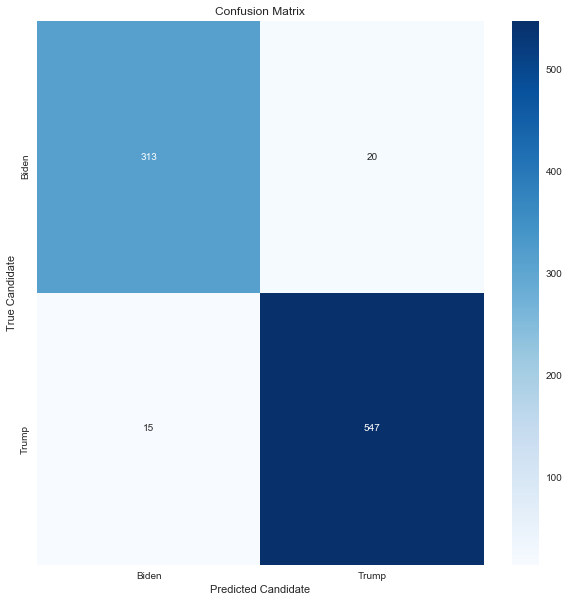

In [110]:
y_pred = eclf.predict(X_test)
print_classification_results(y_pred, y_test, "Voting Classifier")

Able to slighly improve accuracy from ~93% to ~95% by using the top 3 individual classifiers together in a voting ensemble. 

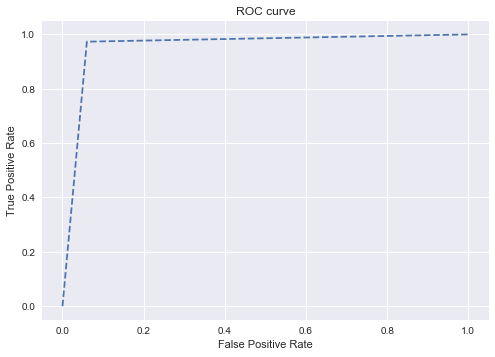

In [111]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show() 